In [1]:
import numpy as np
import pandas as pd

import sys
import os

import PIL

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torchvision.models import *
import torch.nn as nn
import torchvision.transforms as transforms
import torch
import torchvision
import torch.nn.functional as F

# from fastai.core import ItemBase
# from fastai.basic_data import DataBunch
from fastai.vision import *
from fastai.basic_data import DataBunch
from fastai.basic_train import Learner
from fastai.torch_core import *
from fastai.basic_data import *
from fastai.callback import *
from fastai.metrics import *
from fastai.callbacks.hooks import num_features_model

from torch.nn.modules import PairwiseDistance

First we need to create the DataFrame whose columns are the subject ID, and the subject photo. This will have a list of all photos in the dataset.

In [11]:
basedir = './data/images/'

In [12]:
df = pd.read_csv('./train_labels.csv')

In [14]:
df = df[['label', 'imgpath']]

In [16]:
df.to_csv('./train_labels_reverse.csv', index=False)

In [3]:
subjectdf = pd.read_csv('./train_labels.csv')
subjectdf.columns = ['subject', 'subject_photo']

### Read in the subjects. The images are in nested folders for each subject ###
subjects = np.unique(subjectdf['subject'])

In [17]:
data = ImageDataBunch.from_csv('.', folder=basedir, csv_labels='train_labels_reverse.csv')

In [27]:
learn = create_cnn(data, resnet18, metrics=[accuracy])

In [28]:
learn.freeze()

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


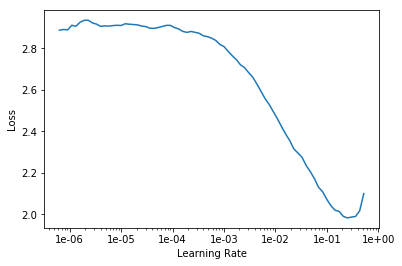

In [30]:
learn.recorder.plot()

In [31]:
lr = 3e-2

In [32]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy
1,0.229831,1.225289,0.759083
2,0.229427,0.173300,0.956917
3,0.130662,0.078490,0.978667
4,0.065473,0.160848,0.986083
5,0.038578,0.035467,0.989083


In [33]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy
1,0.148711,0.471481,0.958500
2,0.188443,0.331142,0.968083
3,0.110474,0.508772,0.976667
4,0.057520,0.038852,0.987583
5,0.043127,0.033190,0.989417


In [34]:
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy
1,0.109833,0.151985,0.965583
2,0.183470,0.146937,0.970583
3,0.128811,0.083789,0.977833
4,0.056111,0.039419,0.987500
5,0.036551,0.035235,0.989083


In [ ]:
learn.fit(5, lr)

epoch,train_loss,valid_loss,accuracy
1,0.180428,0.143249,0.967083
2,0.194888,0.110863,0.977583
3,0.216904,0.125751,0.974833
4,0.153402,0.194125,0.961333


Now let's create train and validation sets

In [3]:
### Split the possible subjects into two groups, train and val ###
subjects_train, subjects_val = train_test_split(subjects, test_size=3, random_state=42)

### All the classes could be used for same and different pairs, since they all have multiple examples ###
same_train, diff_train = (subjects_train, subjects_train)
same_val, diff_val = (subjects_val, subjects_val)

### Create dataframes for each train and validation ###
traindf = subjectdf[subjectdf['subject'].map(lambda x: x in subjects_train)]
valdf = subjectdf[subjectdf['subject'].map(lambda x: x in subjects_val)]

### Find out how many total images are in each, an epoch should create a pair from each (approximately) ###
train_images_per_epoch = traindf.shape[0]
val_images_per_epoch = valdf.shape[0]

In [4]:
subjects_train

array([0, 7, 2, 9, 4, 3, 6])

In [5]:
class SiameseDataset(Dataset):
    def __init__(self, data_path, df, categories, id_col, image_col, images_per_epoch, transforms=None):
        """
        data_path : the high level path to get to the data folder. This could end up being the folder 
        containing all the images in a flat structure, or it could be the folder containing folders for each subject"
        id_col    : the column that contains the id of the individual object (of which there may be multiple pictures
        that will each be listed in the image_col)
        image_col : the column that contains the path to the specific image, starting in data_path"""
        self.c = 1
        self.data_path = data_path
        self.df = df
        self.categories = categories
        self.id_col = id_col
        self.image_col = image_col
        self.images_per_epoch = images_per_epoch
        self.transform = transforms
        
    def __len__(self):
        return self.images_per_epoch #len(diff)
        
    def __getitem__(self, index):
        ### We will need to draw pairs of similar images as often as dissimilar images ###
        ### This will also function as the label we pass ###
        np.random.seed(index)
        
        ### Choose a random positive and negative category ###
        pos_cat_ind, neg_cat_ind = np.random.choice(self.categories, size=2, replace=False)
        
        ### Choose two positive image indices, one negative image index ###
        pos_imgs = self.df[self.df[self.id_col]==pos_cat_ind][self.image_col].values
        neg_imgs = self.df[self.df[self.id_col]==neg_cat_ind][self.image_col].values
        
        ### Choose the actual anchor, positive, negative images ###
        anc_img, pos_img = np.random.choice(pos_imgs, size=2, replace=False)
        neg_img = np.random.choice(neg_imgs)
        
        anc_img = PIL.Image.open(self.data_path + anc_img)
        pos_img = PIL.Image.open(self.data_path + pos_img)
        neg_img = PIL.Image.open(self.data_path + neg_img)
        
        anc_img = anc_img.convert('RGB')
        pos_img = pos_img.convert('RGB')
        neg_img = neg_img.convert('RGB')
        
        if self.transform is not None:
            anc_img = self.transform(anc_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)
            
        anc_img = np.array(anc_img, dtype=np.float32)
        pos_img = np.array(pos_img, dtype=np.float32)
        neg_img = np.array(neg_img, dtype=np.float32)
        
        return torch.from_numpy(np.array([anc_img, pos_img, neg_img])), torch.from_numpy(np.array([0.0], dtype=np.float32))


In [6]:
class TripletLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, alpha=0.4):
        super(TripletLoss, self).__init__()
        self.alpha = alpha

    def forward(self, outputs, label):
        anc_output, pos_output, neg_output = outputs
        anc_pos_dist = F.pairwise_distance(anc_output, pos_output)
        anc_neg_dist = F.pairwise_distance(anc_output, neg_output)
        diff_dist = anc_pos_dist - anc_neg_dist
#         print("TripletLoss", diff_dist.size())
#         print(torch.clamp(diff_dist + self.alpha, min=0.0))
        loss_triplet = torch.mean(torch.clamp(diff_dist + self.alpha, min=0.0))#, 2)
        return loss_triplet
    
class SiameseNetwork(nn.Module):
    def __init__(self, transfer_arch):
        super(SiameseNetwork, self).__init__()
        
        ### The transfer neural network, without any fully connected layers ###
#         self.nf = 2
        self.nc = 2 # This is effectively the embedding layer degree
        
        body = create_body(transfer_arch)
        nf = num_features_model(body) * 2
        
        head = create_head(nf, self.nc)
        self.network = nn.Sequential(body, head)

    def forward_once(self, x):
        output = self.network(x)
        return output

    def forward(self, input_tuple):
        anc_input = input_tuple[:,0,:,:]
        pos_input = input_tuple[:,1,:,:]
        neg_input = input_tuple[:,2,:,:]
        
#         print(anc_input.size(), pos_input.size(), neg_input.size())
#         fig=plt.figure(figsize=(10, 30))
    
#         img1 = np.array(anc_input[0])
#         img2 = np.array(pos_input[0])
#         img3 = np.array(neg_input[0])

#         img1 = np.moveaxis(img1, 0, -1)
#         img2 = np.moveaxis(img2, 0, -1)
#         img3 = np.moveaxis(img3, 0, -1)

#         fig.add_subplot(1, 3, 1)
#         plt.imshow(img1)

#         fig.add_subplot(1, 3, 2)
#         plt.imshow(img2)

#         fig.add_subplot(1, 3, 3)
#         plt.imshow(img3)

        anc_output = self.forward_once(anc_input)
        pos_output = self.forward_once(pos_input)
        neg_output = self.forward_once(neg_input)

        return (anc_output, pos_output, neg_output)

In [7]:
SiameseTransforms = transforms.Compose([
    transforms.Resize(224),
#     transforms.CenterCrop(224),
#     transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
train_images_per_epoch = 1000
val_images_per_epoch = 500

In [9]:
train_dataset = SiameseDataset(basedir,
                               subjectdf,
                               same_train,
                               'subject',
                               'subject_photo',
                               train_images_per_epoch,
                               transforms=SiameseTransforms)

val_dataset = SiameseDataset(basedir, 
                               subjectdf, 
                               same_val,
                               'subject', 
                               'subject_photo', 
                               val_images_per_epoch,
                               transforms=SiameseTransforms)

In [10]:
split_dict = {'resnet18': [26, 50],'resnet34': [41, 90], 'resnet50': [57, 124]}

In [11]:
train_dataloader = DataLoader(train_dataset, num_workers=8, batch_size=128, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   num_workers=8, batch_size=128, shuffle=True)

mydb = DataBunch(train_dl=train_dataloader, valid_dl=val_dataloader)

# criterion = ContrastiveLoss(margin=2.0)
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCELoss()
criterion = TripletLoss()



model_name = 'resnet18'
net = SiameseNetwork(resnet18)#.cuda()
# optimizer = torch.optim.Adam(net.parameters(),lr = 0.0005 )

learn = Learner(mydb, net, loss_func=criterion)

learn.split(split_model_idx(net, split_dict[model_name]))

In [12]:
def loss_batch(model:nn.Module, xb:Tensor, yb:Tensor, loss_func:OptLossFunc=None, opt:OptOptimizer=None,
               cb_handler:Optional[CallbackHandler]=None)->Tuple[Union[Tensor,int,float,str]]:
    "Calculate loss and metrics for a batch, call out to callbacks as necessary."
    cb_handler = ifnone(cb_handler, CallbackHandler())
    if not is_listy(xb): xb = [xb]
    if not is_listy(yb): yb = [yb]
    out = model(*xb)
    out = cb_handler.on_loss_begin(out)

    if not loss_func: return to_detach(out), yb[0].detach()
    loss = loss_func(out, *yb)

    if opt is not None:
        loss = cb_handler.on_backward_begin(loss)
        loss.backward()
        cb_handler.on_backward_end()
        opt.step()
        cb_handler.on_step_end()
        opt.zero_grad()

    return loss.detach().cpu()

def fit(epochs:int, model:nn.Module, loss_func:LossFunction, opt:optim.Optimizer,
        data:DataBunch, callbacks:Optional[CallbackList]=None, metrics:OptMetrics=None)->None:
    "Fit the `model` on `data` and learn using `loss_func` and `opt`."
    cb_handler = CallbackHandler(callbacks, metrics)
    pbar = master_bar(range(epochs))
    cb_handler.on_train_begin(epochs, pbar=pbar, metrics=metrics)

    exception=False
    try:
        for epoch in pbar:
            model.train()
            cb_handler.on_epoch_begin()

            for xb,yb in progress_bar(data.train_dl, parent=pbar):
                xb, yb = cb_handler.on_batch_begin(xb, yb)
                loss = loss_batch(model, xb, yb, loss_func, opt, cb_handler)
                if cb_handler.on_batch_end(loss): break

            if not data.empty_val:
                val_loss = validate(model, data.valid_dl, loss_func=loss_func,
                                       cb_handler=cb_handler, pbar=pbar)
            else: val_loss=None
            if cb_handler.on_epoch_end(val_loss): break
    except Exception as e:
        exception = e
        raise e
    finally: cb_handler.on_train_end(exception)

In [13]:
# fit(1, net, criterion, optimizer, mydb)

In [14]:
learn.freeze()

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


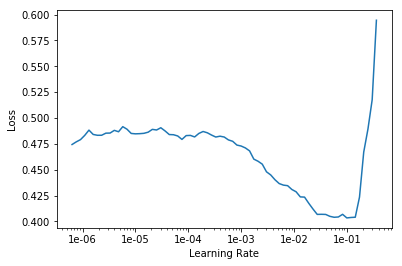

In [16]:
learn.recorder.plot()

In [16]:
lr = 1e-2

In [ ]:
learn.fit_one_cycle(15, lr)

epoch,train_loss,valid_loss
1,0.461930,0.301354
2,0.416955,0.326019
3,0.339020,0.267072
4,0.282097,0.230066
5,0.231260,0.225294
6,0.188575,0.208400
7,0.156521,0.294450
8,0.129835,0.252406
9,0.109538,0.278372
10,0.093244,0.305231


In [17]:
learn.fit_one_cycle(3, lr)

epoch,train_loss,valid_loss
1,0.146160,0.215044
2,0.120280,0.190227
3,0.093918,0.212596


In [21]:
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss
1,0.440370,0.499916
2,0.403014,0.545388
3,0.352371,0.561212
4,0.317491,0.539081


In [22]:
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss
1,0.236876,0.519495
2,0.209011,0.684732
3,0.207180,0.730241
4,0.202200,0.748287


In [19]:
learn.unfreeze()

In [20]:
learn.fit_one_cycle(5, max_lr=(lr/100, lr/10, lr))

epoch,train_loss,valid_loss
1,0.102191,0.357697
2,0.122440,0.271680
3,0.105015,0.399299
4,0.081012,0.262619
5,0.064361,0.267364


In [23]:
learn.fit_one_cycle(10, max_lr=(lr/9, lr/3, lr))

epoch,train_loss,valid_loss
1,0.307312,0.449589
2,0.288185,0.550074
3,0.275558,0.498870
4,0.259907,0.738709
5,0.245133,0.854851
6,0.235049,0.787350
7,0.211358,0.655459
8,0.188802,0.650514
9,0.169588,0.656177
10,0.153317,0.604898


In [44]:
learn.fit_one_cycle(5, max_lr=(lr/100, lr/10, lr))

epoch,train_loss,valid_loss
1,0.386897,0.623558
2,0.385231,0.645958
3,0.390373,0.627310
4,0.378361,0.485790
5,0.353262,0.573407


In [45]:
learn.fit_one_cycle(5, max_lr=(lr/100, lr/10, lr))

epoch,train_loss,valid_loss
1,0.298835,0.548598
2,0.318626,0.724018
3,0.352443,0.556360
4,0.352517,0.532531
5,0.327011,0.552339


In [43]:
learn.fit_one_cycle(5, max_lr=(lr/100, lr/10, lr))

epoch,train_loss,valid_loss
1,1.103696,1.156353
2,1.109264,1.145077
3,1.146942,1.167059
4,1.137867,1.153665
5,1.127420,1.198461


In [26]:
learn.fit_one_cycle(5, max_lr=(lr/100, lr/10, lr))

epoch,train_loss,valid_loss
1,1.104511,1.395385
2,1.119389,1.326514
3,1.128091,1.240161
4,1.121707,1.221313
5,1.119093,1.222916


In [25]:
learn.fit_one_cycle(10, max_lr=(lr/100, lr/10, lr))

epoch,train_loss,valid_loss
1,1.227099,1.270347
2,1.234191,1.225832
3,1.231897,1.392275
4,1.254306,17.089964
5,1.266825,1.621964
6,1.260579,1.296629
7,1.259919,1.251732
8,1.250539,1.250920
9,1.239844,1.214334
10,1.235107,1.234526


In [11]:
learn.fit_one_cycle(15, lr)

epoch,train_loss,valid_loss
1,4.693735,2.839847
2,3.032267,3.635119
3,2.356925,2.898467
4,1.990452,2.002136
5,1.771286,1.584886
6,1.624883,1.329373
7,1.520576,1.177195
8,1.441179,1.072505
9,1.379420,1.016409
10,1.330101,1.008080


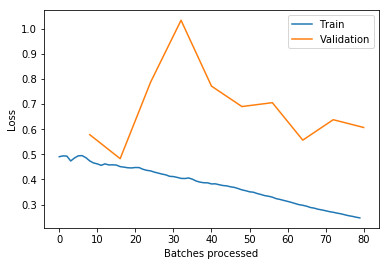

In [24]:
learn.recorder.plot_losses()

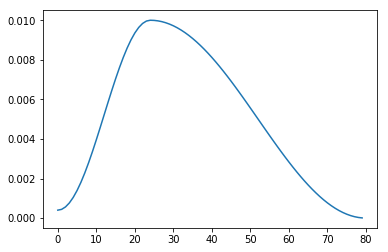

In [25]:
learn.recorder.plot_lr()

## Look at the predictions and see if there is a correlation of label and the distance between the embeddings.

In [33]:
opset = next(iter(train_dataloader))

In [34]:
len(opset)

2

In [35]:
opset[0].size()

torch.Size([8, 3, 3, 224, 224])

In [33]:
# pairs = net(opset[0].cuda())

In [ ]:
opset

In [49]:
pw = PairwiseDistance()

In [50]:
from torch.nn.modules import PairwiseDistance

In [51]:
pwdist = np.array(pw(pairs[0], pairs[1]))

RuntimeError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [52]:
pwlabel = np.array(opset[1])

In [51]:
distdf = pd.DataFrame(pwdist, columns=['dist'])
distdf['lab'] = pwlabel

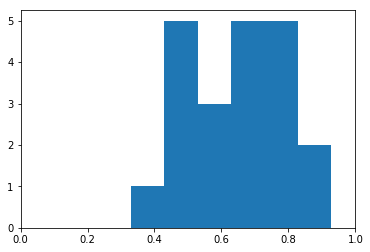

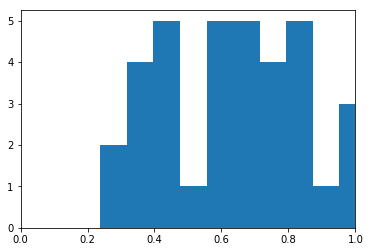

In [52]:
plt.hist(distdf[distdf['lab']==0]['dist']); plt.xlim([0,1]); plt.show()
plt.hist(distdf[distdf['lab']==1]['dist']); plt.xlim([0,1]); plt.show()

## Debug why the network is not training up

In [34]:
set(same_train).intersection(set(same_val))

set()

So let's test if the datasets are really being generated appropiately.

In [57]:
train_dataset_iter = iter(train_dataset)

In [62]:
tst = next(train_dataset_iter)

In [63]:
tst[0].size()

torch.Size([3, 224, 224])

In [64]:
img1 = np.array(tst[0])
img2 = np.array(tst[1])
img3 = np.array(tst[2])

img1 = np.moveaxis(img1, 0, -1)
img2 = np.moveaxis(img2, 0, -1)
img3 = np.moveaxis(img3, 0, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


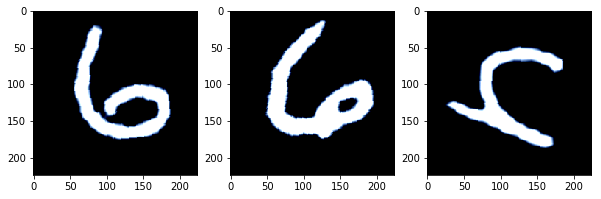

In [66]:
fig=plt.figure(figsize=(10, 30))

fig.add_subplot(1, 3, 1)
plt.imshow(img1)

fig.add_subplot(1, 3, 2)
plt.imshow(img2)

fig.add_subplot(1, 3, 3)
plt.imshow(img3)

In [45]:
# img1 = np.array(tst[0][0])
# img2 = np.array(tst[0][1])
# lbl = tst[1]
# img1 = np.moveaxis(img1, 0, -1)
# img2 = np.moveaxis(img2, 0, -1)

In [46]:
# np.array(lbl, dtype=np.int8)[0]

In [72]:
train_dataset_iter = iter(train_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

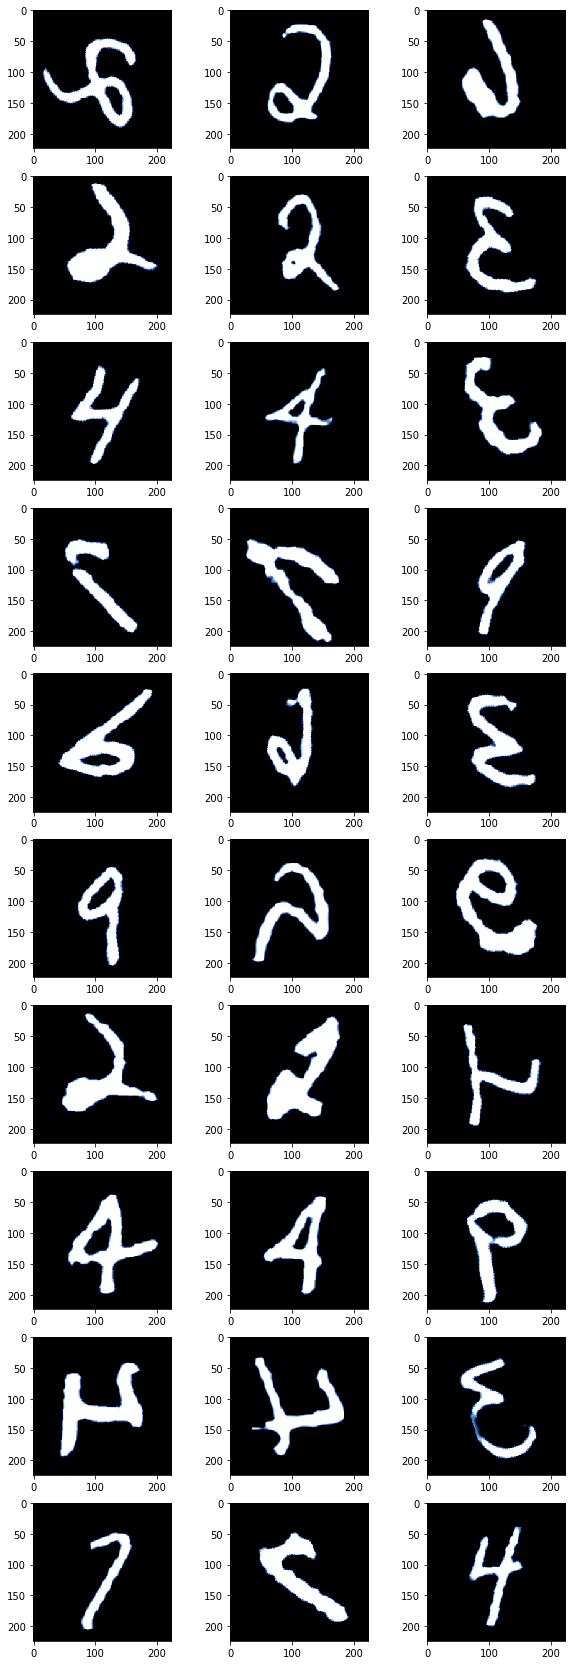

In [74]:
w=10
h=10
fig=plt.figure(figsize=(10, 30))
columns = 3
rows = 10

for i in range(1, columns*rows +1, 3):
    
    tst = next(train_dataset_iter)
    
    img1 = np.array(tst[0])
    img2 = np.array(tst[1])
    img3 = np.array(tst[2])

    img1 = np.moveaxis(img1, 0, -1)
    img2 = np.moveaxis(img2, 0, -1)
    img3 = np.moveaxis(img3, 0, -1)
    
    fig.add_subplot(rows, columns, i)
    plt.imshow(img1)
    
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img2)
    
    fig.add_subplot(rows, columns, i+2)
    plt.imshow(img3)

plt.show()

So the dataset seems to be generating images correctly. Let's do the same check on the dataloader.

In [80]:
opset = next(iter(train_dataloader))

In [81]:
opset[0].size()

torch.Size([8, 2, 3, 224, 224])

In [105]:
labels = np.array(opset[1])

So this tensor contains a batch of the image pairs. Let's make the batch smaller (to 8).

In [94]:
pairs = net(opset[0].cuda())

torch.Size([8, 3, 224, 224]) torch.Size([8, 3, 224, 224])


In [99]:
pairs[0].size(), pairs[1].size()

(torch.Size([8, 3, 224, 224]), torch.Size([8, 3, 224, 224]))

In [100]:
pairs1 = np.array(pairs[0])
pairs2 = np.array(pairs[1])

pairs1 = np.moveaxis(pairs1, 1, -1)
pairs2 = np.moveaxis(pairs2, 1, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

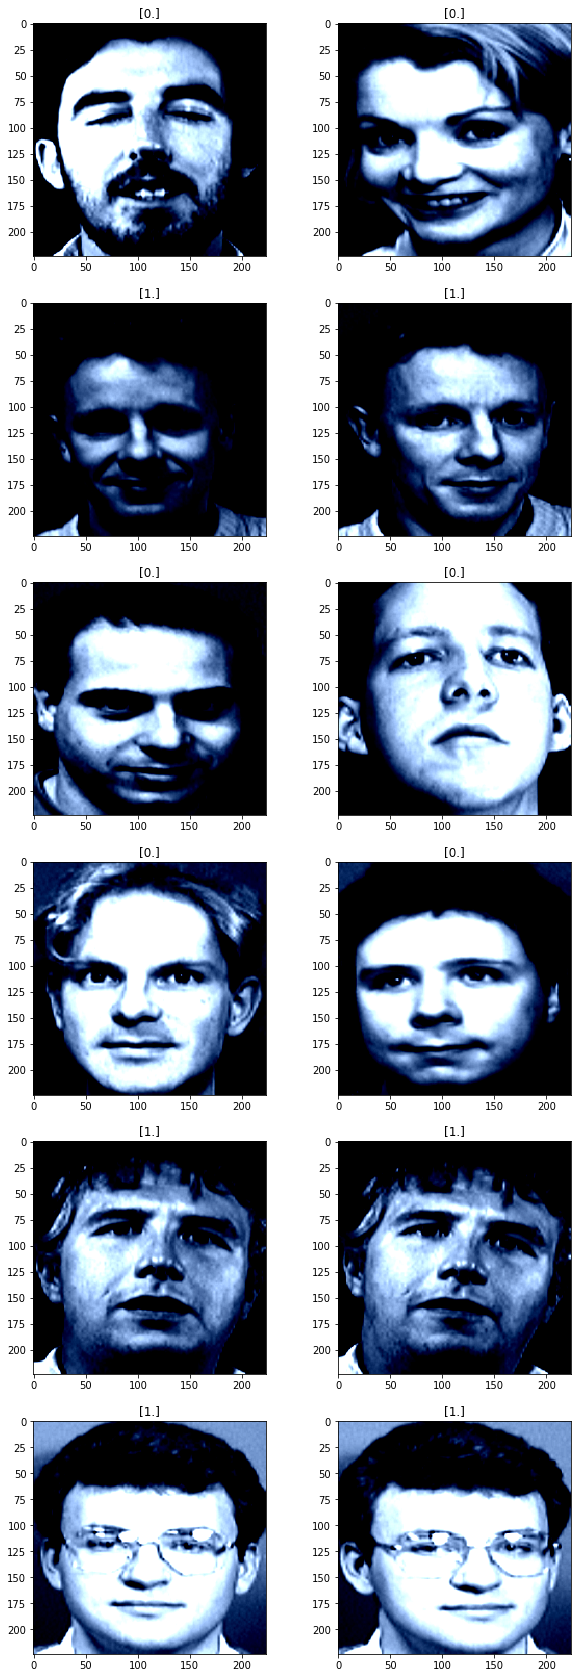

In [106]:
w=10
h=10
fig=plt.figure(figsize=(10, 30))
columns = 2
rows = 6
for i in range(0, rows):
    
    img1 = pairs1[i]
    img2 = pairs2[i]
    
    lbl = labels[i]
#     lbl = np.array(lbl, dtype=np.int8)[0]
#     img1 = np.moveaxis(img1, 0, -1)
#     img2 = np.moveaxis(img2, 0, -1)
    
    fig.add_subplot(rows, columns, 2*i+1)
    plt.imshow(img1)
    plt.title(str(lbl))
    
    fig.add_subplot(rows, columns, 2*i+2)
    plt.imshow(img2)
    plt.title(str(lbl))

plt.show()

Let's make sure the images are getting loaded in and transformed correctly, as they seem to be pairing up. Also need to double check the labeling, but we have tried it both ways so this is probably not it.

In [144]:
img1 = PIL.Image.open('../orl_faces/s1/1.pgm')
img2 = PIL.Image.open('../orl_faces/s1/2.pgm')

img1 = img1.convert('RGB')
img2 = img2.convert('RGB')

SiameseTransforms2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img1 = SiameseTransforms2(img1)
img2 = SiameseTransforms2(img2)

img1 = np.array(img1, dtype=np.float32)
img2 = np.array(img2, dtype=np.float32)

# np.array(img1).max()
img1.max(), img2.max(), img1.min(), img2.min()

(2.0299783, 1.6988237, -1.8610327, -2.0665298)

So the arrays seem to be scaling correctly. Perhaps I am feeding in data incorrectly, or pulling it out incorrectly?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


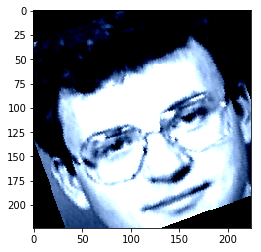

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


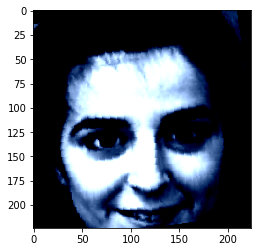

In [62]:
tst = next(iter(train_dataloader))

imgs = tst[0]

imgs1 = imgs[:,0,:,:]
imgs2 = imgs[:,1,:,:]

plt.imshow(np.moveaxis(np.array(imgs1[0]), 0, -1)); plt.show()
plt.imshow(np.moveaxis(np.array(imgs1[1]), 0, -1)); plt.show()

In [75]:
img1 = PIL.Image.open('../orl_faces/s1/1.pgm')
img2 = PIL.Image.open('../orl_faces/s1/2.pgm')

In [76]:
img1.size

(92, 112)